# Q4: How does CCM respond to relaxation of A1: C contain information about S
# Q5: How does CCM respond to relaxation of A2: S contain information outside of C

I'm going to include $\tilde{C} = [C, \text{onehot}(S)]$

In [9]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn.metrics import average_precision_score
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform, shortcut_noise_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

# Q5: note the evaluation result is only valid for T=1 because clean still gives the net_s

The C+S models gives 65.8% on biased dataset versus the C model only gives 57.7%

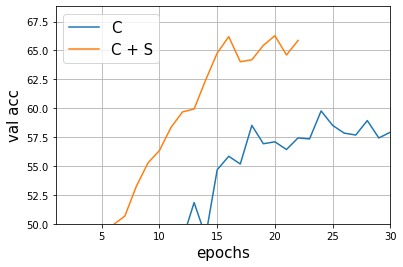

In [31]:
key = 'val acc'
plot_log(torch.load("../outputs/dnoise100/7ef5dec0f45a11ebb773ac1f6b24a434/cbm.log"), key=key, label="C")
plot_log(torch.load("../outputs/2b477560137a11ecb773ac1f6b24a434/cbm.log"), key=key, label="C + S")
plt.xlim([1, 30])
plt.ylim(50)
plt.grid()
plt.legend(fontsize=15)
plt.ylabel(key)
plt.show()